In [2]:
import os
import shutil
import numpy as np
import cv2
from random import shuffle
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from collections import Counter


2022-11-16 20:28:20.453662: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
!nvidia-smi
tf.config.list_physical_devices('GPU')


Wed Nov 16 18:08:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P40           On   | 00000000:42:00.0 Off |                    0 |
| N/A   72C    P8    19W / 250W |      4MiB / 23040MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 分类数据

In [3]:
DataDir = "/home/eduarte/Documents/DataSets/CovidCT/"
TrainMeta = DataDir + "train_COVIDx_CT-3A.txt"
TestMeta = DataDir + "test_COVIDx_CT-3A.txt"
ValidateMeta = DataDir + "val_COVIDx_CT-3A.txt"
# 图片文件名 [分类：健康 0，普通肺炎 1，新冠 2] x_start y_start x_end y_end <= 裁切范围
# 数据集 https://www.kaggle.com/datasets/hgunraj/covidxct
!head -n 10 {TrainMeta}


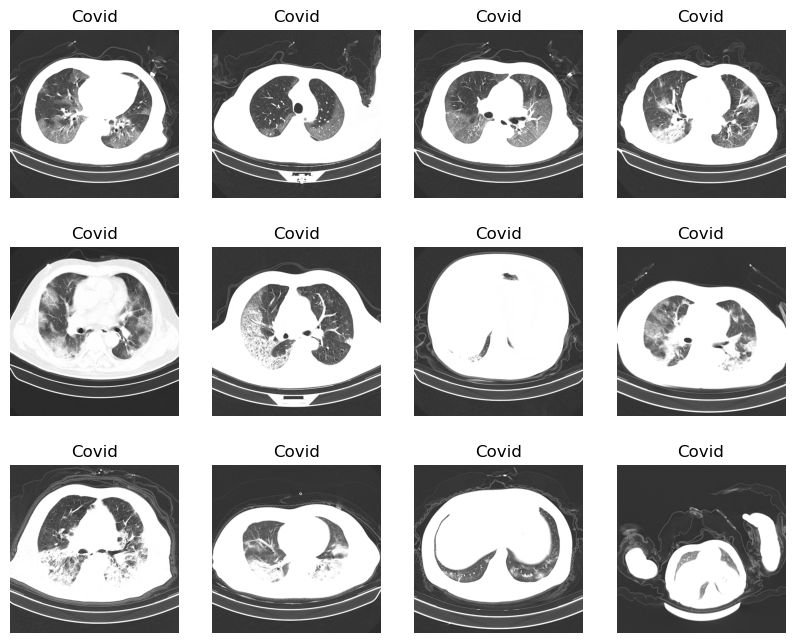

In [16]:
ImgClasses = ["Healthy", "Pneumonia", "Covid"]
SampleImgList = open(TrainMeta).read().split("\n")
plt.figure(figsize=(10, 8))
for i in range(12):
    Row = SampleImgList[i * 100].split(" ")
    Img = cv2.imread(DataDir + "3A_images/" + ImgName)
    ImgName = Row[0]
    plt.subplot(3, 4, i + 1)
    plt.axis('off')
    plt.imshow(Img)
    plt.title(ImgClasses[int(Row[1])])


In [4]:
# 根据灰度图像深色像素占比简单筛出肺部CT
def isThroaxCT(image):
    img = cv2.cvtColor(cv2.resize(image, (40, 40), interpolation=cv2.INTER_AREA), cv2.COLOR_RGB2GRAY)
    x, y = img.shape
    black = 0
    white = 0
    for i in range(x):
        for j in range(y):
            if img[i,j] > 150:
                white += 1
            else:
                black += 1
    if black / (x * y) >= 0.3:
        return True
    return False
    

In [5]:
!rm -rf {DataDir}Training/
!mkdir -p {DataDir}Training/Covid/
!mkdir {DataDir}Training/Healthy/
!mkdir {DataDir}Training/Pneumonia/
!ls -lh {DataDir}Training/


总用量 12K
drwxrwxr-x 2 eduarte eduarte 4.0K 11月 16 18:08 Covid
drwxrwxr-x 2 eduarte eduarte 4.0K 11月 16 18:08 Healthy
drwxrwxr-x 2 eduarte eduarte 4.0K 11月 16 18:08 Pneumonia


In [6]:
## 使用的样本数量 /每类
DataScale = 5000
TrainImgList = open(TrainMeta).read().split("\n")
ImgClasses = ["Healthy", "Pneumonia", "Covid"]
ImgCnt = [0, 0, 0]
for i in tqdm(range(0, len(TrainImgList)), "Processing"):
    Row = TrainImgList[i].split(" ")
    if len(Row) > 1:
        ImgName = Row[0]
        ImgClass = ImgClasses[int(Row[1])]
        if ImgCnt[int(Row[1])] < DataScale:
            Image = cv2.imread(DataDir + "3A_images/" + ImgName)
            Cropped = Image[int(Row[3]):int(Row[5]), int(Row[2]):int(Row[4]), :]
            if isThroaxCT(Cropped):
                ImgCnt[int(Row[1])] += 1
                Resized = cv2.resize(Cropped, (224, 224), interpolation = cv2.INTER_AREA)
                cv2.imwrite(DataDir + "Training/" + ImgClass + "/" + ImgName, Resized)


Processing: 100%|█████████████████████| 357519/357519 [05:05<00:00, 1171.01it/s]


In [17]:
CovidImages = os.listdir(DataDir + "Training/Covid")
HealthyImages = os.listdir(DataDir + "Training/Healthy")
PneumoniaImages = os.listdir(DataDir + "Training/Pneumonia")

print("新冠样本数:", len(CovidImages))
print("健康样本数:", len(HealthyImages))
print("肺炎样本数:", len(PneumoniaImages))
NUM_TRAINING_IMAGES = len(CovidImages) + len(HealthyImages) + len(PneumoniaImages)
print("有效样本合计:", NUM_TRAINING_IMAGES)


新冠样本数: 5000
健康样本数: 5000
肺炎样本数: 5000
有效样本合计: 15000


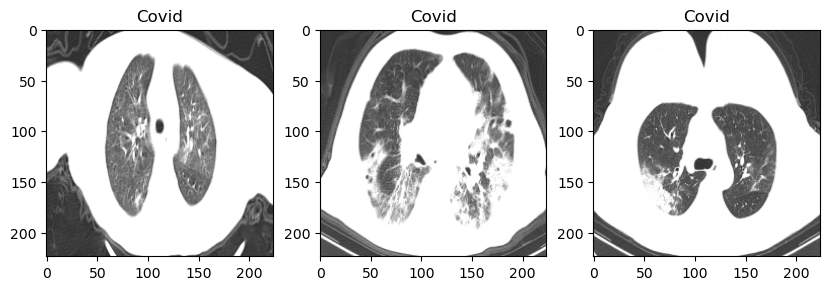

In [8]:
plt.figure(figsize=(10, 10))
for i in range(3):
    plt.subplot(3, 3, i + 1)
    plt.imshow(
        plt.imread(
            os.path.join(
                DataDir + "Training/Covid",
                CovidImages[i]
            )
        ), 
        cmap='gray'
    )
    plt.title("Covid")
plt.show()

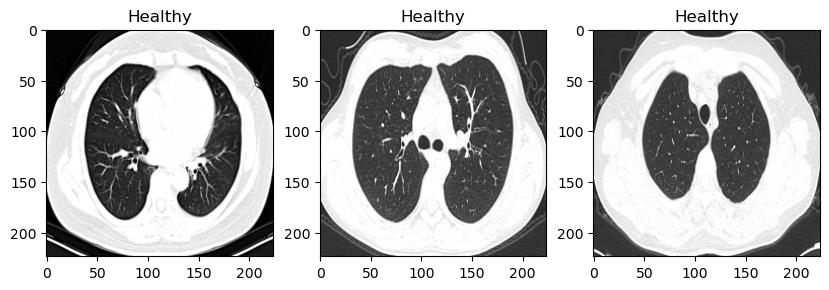

In [9]:
plt.figure(figsize=(10, 10))
for i in range(3):
    plt.subplot(3, 3, i + 1)
    plt.imshow(
        plt.imread(
            os.path.join(
                DataDir + "Training/Healthy",
                HealthyImages[i]
            )
        ), 
        cmap='gray'
    )
    plt.title("Healthy")
plt.show()

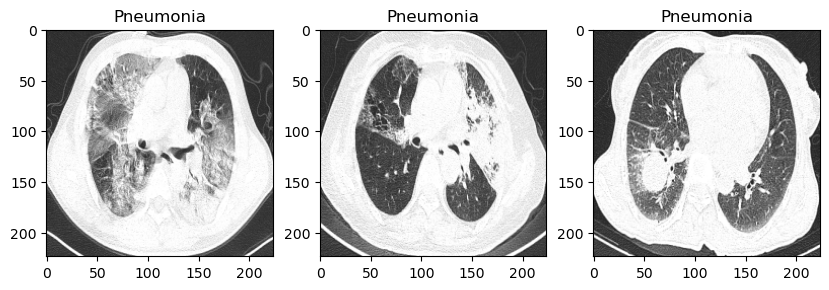

In [10]:
plt.figure(figsize=(10, 10))
for i in range(3):
    plt.subplot(3, 3, i + 1)
    plt.imshow(
        plt.imread(
            os.path.join(
                DataDir + "Training/Pneumonia",
                PneumoniaImages[i]
            )
        ), 
        cmap='gray'
    )
    plt.title("Pneumonia")
plt.show()

In [11]:
!rm -rf {DataDir}Testing/
!mkdir -p {DataDir}Testing/Covid/
!mkdir {DataDir}Testing/Healthy/
!mkdir {DataDir}Testing/Pneumonia/
!ls -lh {DataDir}Testing/


总用量 12K
drwxrwxr-x 2 eduarte eduarte 4.0K 11月 16 18:14 Covid
drwxrwxr-x 2 eduarte eduarte 4.0K 11月 16 18:14 Healthy
drwxrwxr-x 2 eduarte eduarte 4.0K 11月 16 18:14 Pneumonia


In [12]:
DataScale = 1000
TestImgList = open(TestMeta).read().split("\n")
ImgClasses = ["Healthy", "Pneumonia", "Covid"]
ImgCnt = [0, 0, 0]
for i in tqdm(range(0, len(TestImgList)), "Processing"):
    Row = TestImgList[i].split(" ")
    if len(Row) > 1:
        ImgName = Row[0]
        ImgClass = ImgClasses[int(Row[1])]
        if ImgCnt[int(Row[1])] < DataScale:
            Image = cv2.imread(DataDir + "3A_images/" + ImgName)
            Cropped = Image[int(Row[3]):int(Row[5]), int(Row[2]):int(Row[4]), :]
            if isThroaxCT(Cropped):
                ImgCnt[int(Row[1])] += 1
                Resized = cv2.resize(Cropped, (224, 224), interpolation = cv2.INTER_AREA)
                cv2.imwrite(DataDir + "Testing/" + ImgClass + "/" + ImgName, Resized)

                #os.symlink(DataDir + "3A_images/" + ImgName, 
                #           DataDir + "Testing/" + ImgClass + "/" + ImgName)


Processing: 100%|████████████████████████| 33782/33782 [00:57<00:00, 586.17it/s]


In [13]:
CovidTestImages = os.listdir(DataDir + "Testing/Covid")
HealthyTestImages = os.listdir(DataDir + "Testing/Healthy")
PneumoniaTestImages = os.listdir(DataDir + "Testing/Pneumonia")

print("新冠样本数:", len(CovidTestImages))
print("健康样本数:", len(HealthyTestImages))
print("肺炎样本数:", len(PneumoniaTestImages))
print("有效样本合计:", len(CovidTestImages) + \
      len(HealthyTestImages) + len(PneumoniaTestImages))


新冠样本数: 1000
健康样本数: 1000
肺炎样本数: 1000
有效样本合计: 3000


In [14]:
!rm -rf {DataDir}Validating/
!mkdir -p {DataDir}Validating/Covid/
!mkdir {DataDir}Validating/Healthy/
!mkdir {DataDir}Validating/Pneumonia/
!ls -lh {DataDir}Validating/


总用量 12K
drwxrwxr-x 2 eduarte eduarte 4.0K 11月 16 18:15 Covid
drwxrwxr-x 2 eduarte eduarte 4.0K 11月 16 18:15 Healthy
drwxrwxr-x 2 eduarte eduarte 4.0K 11月 16 18:15 Pneumonia


In [15]:
DataScale = 1000
ValidateImgList = open(ValidateMeta).read().split("\n")
ImgClasses = ["Healthy", "Pneumonia", "Covid"]
ImgCnt = [0, 0, 0]
for i in tqdm(range(0, len(ValidateImgList)), "Processing"):
    Row = ValidateImgList[i].split(" ")
    if len(Row) > 1:
        ImgName = Row[0]
        ImgClass = ImgClasses[int(Row[1])]
        if ImgCnt[int(Row[1])] < DataScale:
            Image = cv2.imread(DataDir + "3A_images/" + ImgName)
            Cropped = Image[int(Row[3]):int(Row[5]), int(Row[2]):int(Row[4]), :]
            if isThroaxCT(Cropped):
                ImgCnt[int(Row[1])] += 1
                Resized = cv2.resize(Cropped, (224, 224), interpolation = cv2.INTER_AREA)
                cv2.imwrite(DataDir + "Validating/" + ImgClass + "/" + ImgName, Resized)


Processing: 100%|████████████████████████| 33726/33726 [00:58<00:00, 575.75it/s]


In [16]:
CovidValImages = os.listdir(DataDir + "Validating/Covid")
HealthyValImages = os.listdir(DataDir + "Validating/Healthy")
PneumoniaValImages = os.listdir(DataDir + "Validating/Pneumonia")

print("新冠样本数:", len(CovidValImages))
print("健康样本数:", len(HealthyValImages))
print("肺炎样本数:", len(PneumoniaValImages))
print("有效样本合计:", len(CovidValImages) + \
      len(HealthyValImages) + len(PneumoniaValImages))


新冠样本数: 1000
健康样本数: 1000
肺炎样本数: 1000
有效样本合计: 3000


## 加载数据集

In [19]:
image_size = 224
BATCH_SIZE = 16
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
train_datagen = ImageDataGenerator(
    rescale = 1. / 255,
    zoom_range = 0.2,
    rotation_range = 15,
    horizontal_flip = True
)
test_datagen = ImageDataGenerator(rescale = 1. / 255)
training_set = train_datagen.flow_from_directory(
    DataDir + "Training/",
    target_size = (image_size, image_size),
    batch_size = BATCH_SIZE,
    class_mode = "categorical",
    shuffle = True
)
testing_set = test_datagen.flow_from_directory(
    DataDir + "Testing/",
    target_size = (image_size, image_size),
    batch_size = BATCH_SIZE,
    class_mode = "categorical",
    shuffle = True
)
validating_set = test_datagen.flow_from_directory(
    DataDir + "Validating/",
    target_size = (image_size, image_size),
    batch_size = BATCH_SIZE,
    class_mode = "categorical",
    shuffle = False
)



Found 15000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.


In [18]:
print("train batch ", training_set.__getitem__(0)[0].shape)
print("test batch ", testing_set.__getitem__(0)[0].shape)
print("sample train label \n", training_set.__getitem__(0)[1][:5])


train batch  (16, 224, 224, 3)
test batch  (16, 224, 224, 3)
sample train label 
 [[0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


In [20]:
training_set.class_indices

{'Covid': 0, 'Healthy': 1, 'Pneumonia': 2}

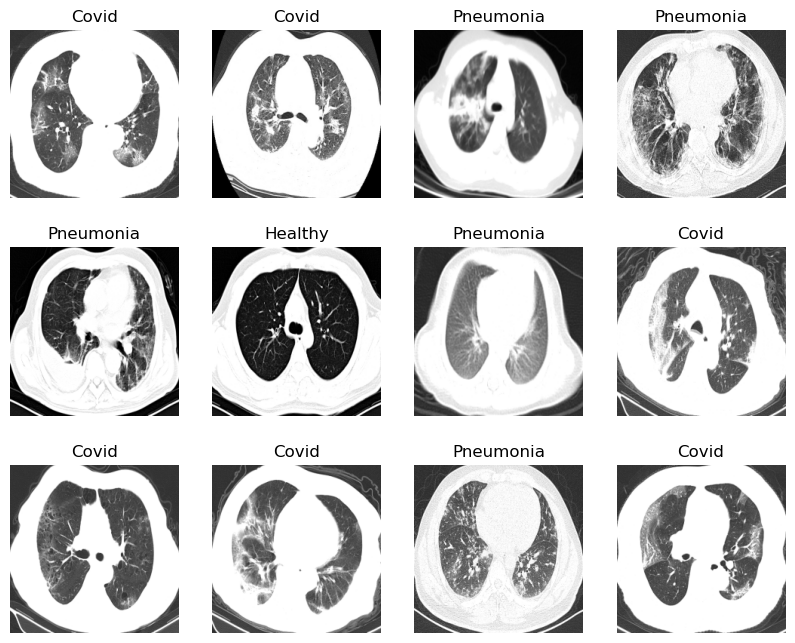

In [19]:
labels = ['Covid', 'Healthy', 'Pneumonia']

sample_data = testing_set.__getitem__(1)[0]
sample_label = testing_set.__getitem__(1)[1]

plt.figure(figsize=(10, 8))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.axis('off')
    plt.imshow(sample_data[i])
    plt.title(labels[np.argmax(sample_label[i])])


In [20]:
def display_training_curves(training, validation, title, subplot):
    if subplot % 10 == 1: # set up the subplots on the first call
        plt.subplots(figsize = (10,10), facecolor = '#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])
    

In [21]:
# https://keras.io/examples/vision/grad_cam/
from tensorflow import keras

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap, top_pred_index.numpy()


In [22]:
# https://keras.io/examples/vision/grad_cam/
def superimposed_img(image, heatmap):
    # We rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # We use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # We use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # We create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((image_size, image_size))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * 0.4 + image
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    return superimposed_img


In [45]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    import itertools
    print(cm)
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black"
        )

    plt.ylabel('Actual')
    plt.xlabel('Predict')
    plt.tight_layout()


In [24]:
# label smoothing https://www.linkedin.com/pulse/label-smoothing-solving-overfitting-overconfidence-code-sobh-phd/
def categorical_smooth_loss(y_true, y_pred, label_smoothing = 0.1):
    loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred, label_smoothing = label_smoothing)
    return loss


In [25]:
# training call backs 
lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(
    monitor = 'val_loss', 
    factor = 0.5, 
    min_delta = 0.0001, 
    patience = 3, 
    verbose = 1
)
es_callback = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss', 
    patience = 5, 
    verbose = 1
)


In [26]:
# https://stackoverflow.com/questions/42586475/is-it-possible-to-automatically-infer-the-class-weight-from-flow-from-directory
counter = Counter(training_set.classes)                          
max_val = float(max(counter.values()))       
class_weights = { class_id : max_val / num_images for class_id, num_images in counter.items() }
class_weights


{0: 1.0, 1: 1.0, 2: 1.0}

In [27]:
# dfault input shapes
print(tf.keras.applications.DenseNet201(weights='imagenet').input_shape)
print(tf.keras.applications.VGG16(weights='imagenet').input_shape)


2022-11-16 18:16:07.329584: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-16 18:16:08.144873: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22131 MB memory:  -> device: 0, name: Tesla P40, pci bus id: 0000:42:00.0, compute capability: 6.1


(None, 224, 224, 3)
(None, 224, 224, 3)


## Densenet201

In [43]:
pretrained_densenet = tf.keras.applications.DenseNet201(
    input_shape = (image_size, image_size, 3), 
    weights = 'imagenet', 
    include_top = False
)

for layer in pretrained_densenet.layers:
  layer.trainable = False

x1 = pretrained_densenet.output
x1 = tf.keras.layers.AveragePooling2D(name = "averagepooling2d_head")(x1)
x1 = tf.keras.layers.Flatten(name = "flatten_head")(x1)
x1 = tf.keras.layers.Dense(64, activation = "relu", name = "dense_head")(x1)
x1 = tf.keras.layers.Dropout(0.5, name = "dropout_head")(x1)
model_out = tf.keras.layers.Dense(3, activation = 'softmax', name = "predictions_head")(x1)

model_densenet = Model(inputs = pretrained_densenet.input, outputs = model_out)
model_densenet.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
    loss = categorical_smooth_loss, 
    metrics = ['accuracy']
)

model_densenet.summary()


Model: "model_50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_29 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_4 (ZeroPadding2  (None, 230, 230, 3)  0          ['input_29[0][0]']               
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d_4[0][0]']       
                                )                                                          

In [44]:
history_densenet = model_densenet.fit(
    training_set, 
    validation_data = testing_set,
    callbacks = [lr_reduce, es_callback],
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs = 30
)


Epoch 1/30
937/937 [==============================] - 221s 224ms/step - loss: 0.5097 - accuracy: 0.9090 - val_loss: 0.4133 - val_accuracy: 0.9450 - lr: 1.0000e-04
Epoch 2/30
937/937 [==============================] - 208s 222ms/step - loss: 0.4337 - accuracy: 0.9541 - val_loss: 0.3949 - val_accuracy: 0.9480 - lr: 1.0000e-04
Epoch 3/30
937/937 [==============================] - 203s 217ms/step - loss: 0.4173 - accuracy: 0.9653 - val_loss: 0.3800 - val_accuracy: 0.9600 - lr: 1.0000e-04
Epoch 4/30
937/937 [==============================] - 209s 223ms/step - loss: 0.4079 - accuracy: 0.9722 - val_loss: 0.4003 - val_accuracy: 0.9403 - lr: 1.0000e-04
Epoch 5/30
937/937 [==============================] - 205s 219ms/step - loss: 0.4002 - accuracy: 0.9744 - val_loss: 0.3588 - val_accuracy: 0.9733 - lr: 1.0000e-04
Epoch 6/30
937/937 [==============================] - 205s 218ms/step - loss: 0.3951 - accuracy: 0.9750 - val_loss: 0.3811 - val_accuracy: 0.9567 - lr: 1.0000e-04
Epoch 7/30
937/937 [==

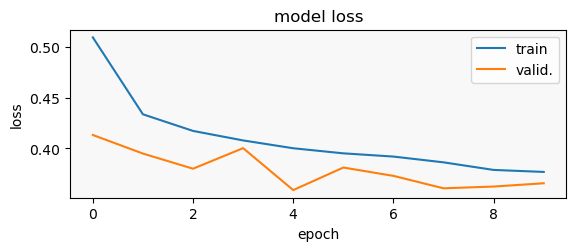

In [46]:
display_training_curves(
    history_densenet.history['loss'], 
    history_densenet.history['val_loss'], 
    'loss', 
    212
)


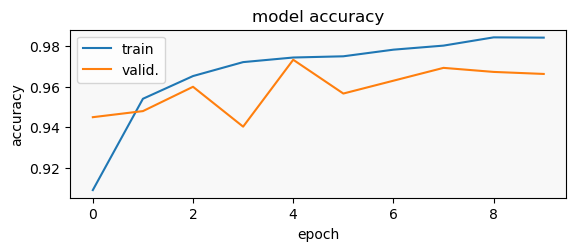

In [47]:
display_training_curves(
    history_densenet.history['accuracy'], 
    history_densenet.history['val_accuracy'], 
    'accuracy', 
    212
)


### 测试

In [48]:
last_conv_layer_name = "conv5_block32_concat"
classifier_layer_names = [
    "bn",
    "relu",
    "averagepooling2d_head",
    "flatten_head",
    "dense_head",
    "dropout_head",
    "predictions_head"
]


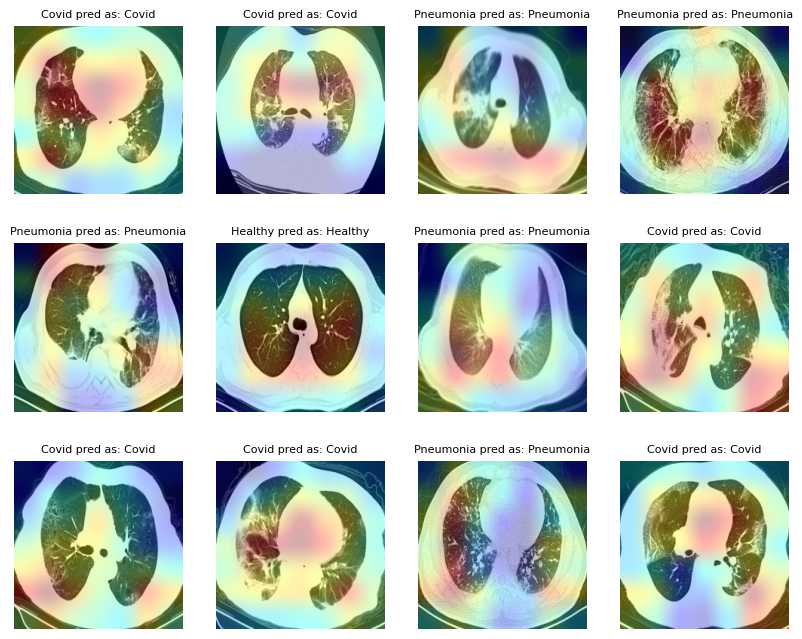

In [49]:
plt.figure(figsize=(10,8))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.axis('off')
    heatmap, top_index = make_gradcam_heatmap(
        np.expand_dims(sample_data[i], axis=0), 
        model_densenet, 
        last_conv_layer_name, 
        classifier_layer_names
    )
    img = np.uint8(255 * sample_data[i])
    s_img = superimposed_img(img, heatmap)
    plt.imshow(s_img)
    title = labels[np.argmax(sample_label[i])] + " pred as: " + labels[top_index]
    if labels[np.argmax(sample_label[i])] != labels[top_index]:
        title = "X " + title
    plt.title(title, fontsize=8)
    


188/188 [==============================] - 15s 61ms/step
[[914   0  86]
 [  0 997   3]
 [ 72   0 928]]


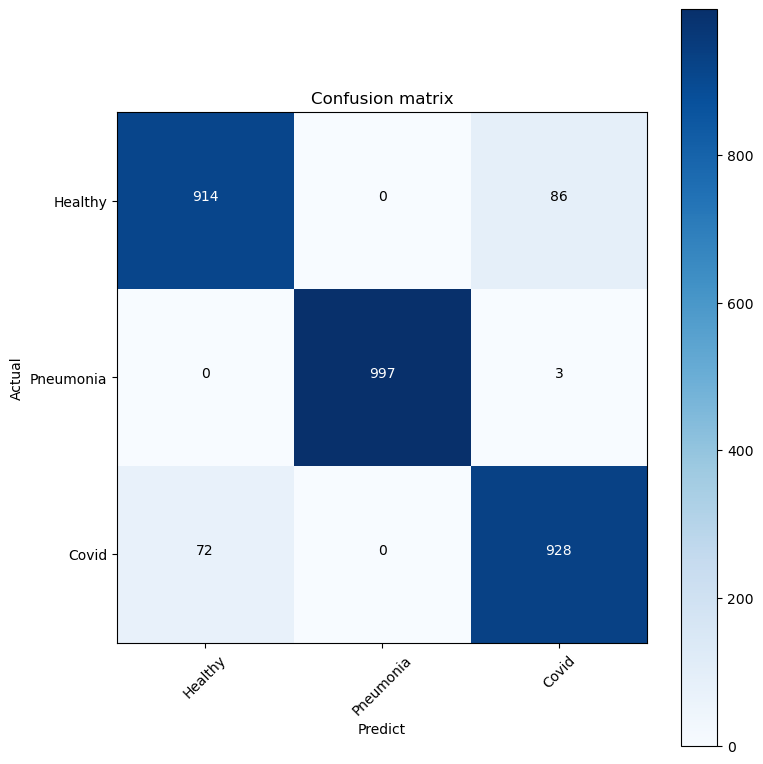

In [50]:
pred_densenet = np.argmax(model_densenet.predict(
    validating_set
), axis = 1)
plot_confusion_matrix(
    confusion_matrix(validating_set.classes, pred_densenet), 
    classes = ["Healthy", "Pneumonia", "Covid"], 
    title = 'Confusion matrix'
)


In [51]:
model_densenet.save(DataDir + "model_densenet.h5")


## VGG16

In [36]:
pretrained_vgg = tf.keras.applications.VGG16(
    input_shape = (image_size, image_size, 3), 
    weights = 'imagenet', 
    include_top = False
)

for layer in pretrained_vgg.layers:
  layer.trainable = False

x2 = pretrained_vgg.output
x2 = tf.keras.layers.AveragePooling2D(name="averagepooling2d_head")(x2)
x2 = tf.keras.layers.Flatten(name="flatten_head")(x2)
x2 = tf.keras.layers.Dense(128, activation="relu", name="dense_head")(x2)
x2 = tf.keras.layers.Dropout(0.5, name="dropout_head")(x2)
x2 = tf.keras.layers.Dense(64, activation="relu", name="dense_head_2")(x2)
x2 = tf.keras.layers.Dropout(0.5, name="dropout_head_2")(x2)
model_out = tf.keras.layers.Dense(3, activation='softmax', name="predictions_head")(x2)

model_vgg = Model(inputs=pretrained_vgg.input, outputs=model_out)
model_vgg.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss=categorical_smooth_loss,metrics=['accuracy'])
model_vgg.summary()


Model: "model_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0  

In [37]:
history_vgg = model_vgg.fit(
    training_set, 
    validation_data = testing_set, 
    callbacks = [lr_reduce, es_callback], 
    epochs = 30
)


Epoch 1/30
938/938 [==============================] - 199s 209ms/step - loss: 0.6856 - accuracy: 0.7749 - val_loss: 0.4515 - val_accuracy: 0.9397 - lr: 1.0000e-04
Epoch 2/30
938/938 [==============================] - 200s 213ms/step - loss: 0.4949 - accuracy: 0.9157 - val_loss: 0.4688 - val_accuracy: 0.8977 - lr: 1.0000e-04
Epoch 3/30
938/938 [==============================] - 197s 210ms/step - loss: 0.4564 - accuracy: 0.9395 - val_loss: 0.4240 - val_accuracy: 0.9360 - lr: 1.0000e-04
Epoch 4/30
938/938 [==============================] - 200s 213ms/step - loss: 0.4399 - accuracy: 0.9479 - val_loss: 0.4500 - val_accuracy: 0.9103 - lr: 1.0000e-04
Epoch 5/30
938/938 [==============================] - 196s 208ms/step - loss: 0.4249 - accuracy: 0.9557 - val_loss: 0.4027 - val_accuracy: 0.9467 - lr: 1.0000e-04
Epoch 6/30
938/938 [==============================] - 198s 211ms/step - loss: 0.4166 - accuracy: 0.9597 - val_loss: 0.3993 - val_accuracy: 0.9440 - lr: 1.0000e-04
Epoch 7/30
938/938 [==

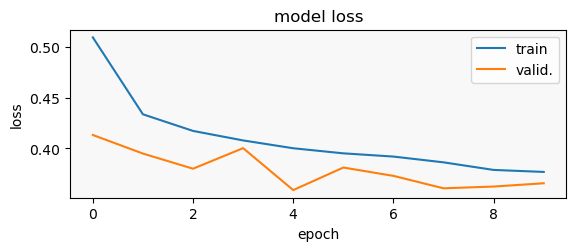

In [52]:
display_training_curves(
    history_densenet.history['loss'], 
    history_densenet.history['val_loss'], 
    'loss', 
    212
)


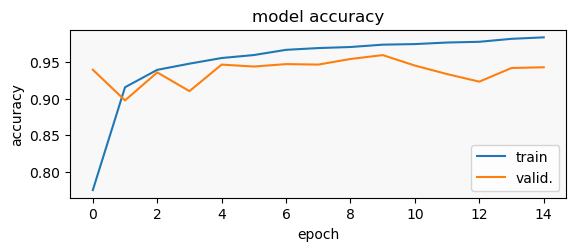

In [38]:
display_training_curves(
    history_vgg.history['accuracy'], 
    history_vgg.history['val_accuracy'], 
    'accuracy', 
    212
)


### 测试

In [39]:
last_conv_layer_name = "block5_pool"
classifier_layer_names = [
    "averagepooling2d_head",
    "flatten_head",
    "dense_head",
    "dropout_head",
    "dense_head_2",
    "dropout_head_2",
    "predictions_head"
]


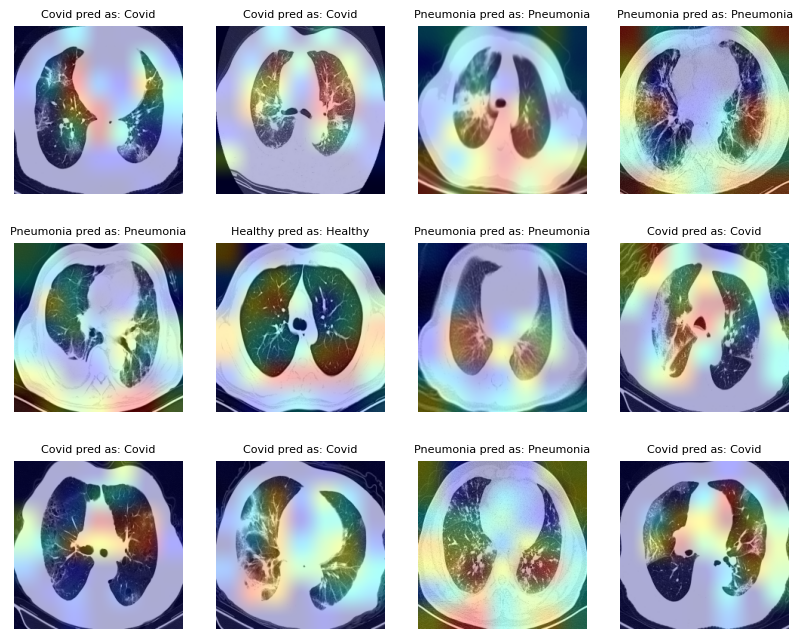

In [40]:
plt.figure(figsize = (10, 8))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.axis('off')
    heatmap, top_index = make_gradcam_heatmap(np.expand_dims(sample_data[i], axis=0), model_vgg, last_conv_layer_name, classifier_layer_names)
    img = np.uint8(255 * sample_data[i])
    s_img = superimposed_img(img, heatmap)
    plt.imshow(s_img)
    title = labels[np.argmax(sample_label[i])] + " pred as: " + labels[top_index]
    if labels[np.argmax(sample_label[i])] != labels[top_index]:
        title  = "X " + title
    plt.title(title, fontsize = 8)


188/188 [==============================] - 8s 40ms/step
[[ 903    5   92]
 [   0 1000    0]
 [  37    1  962]]


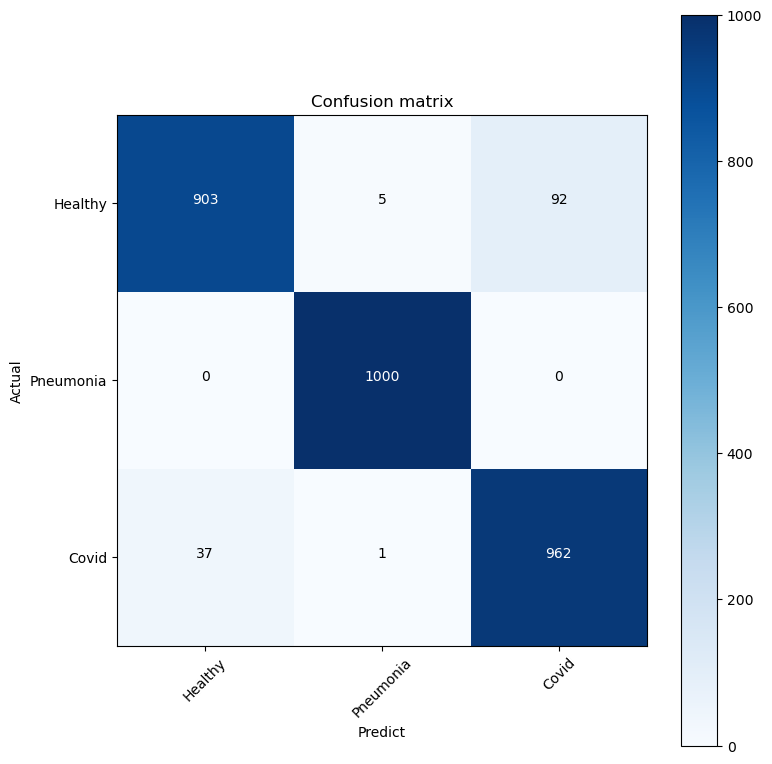

In [53]:
pred_vgg = np.argmax(model_vgg.predict(
    validating_set
), axis = 1)
plot_confusion_matrix(
    confusion_matrix(validating_set.classes, pred_vgg), 
    classes = ["Healthy", "Pneumonia", "Covid"], 
    title = 'Confusion matrix'
)



In [54]:
model_vgg.save(DataDir + "model_vgg.h5")
